# Chapter 3 - Inferences with binomials

In [1]:
using Pkg
using DynamicPPL, Turing
using StatsPlots, Random
using LaTeXStrings
using CSV
using DataFrames
using SpecialFunctions

In [2]:
format=:png

:png

In [3]:
Random.seed!(6)

TaskLocalRNG()

## 3.1 Inferring a rate

$$ \theta \sim \text{Beta}(1, 1)  $$
$$ k \sim \text{Binomial} ( \theta, n)  $$

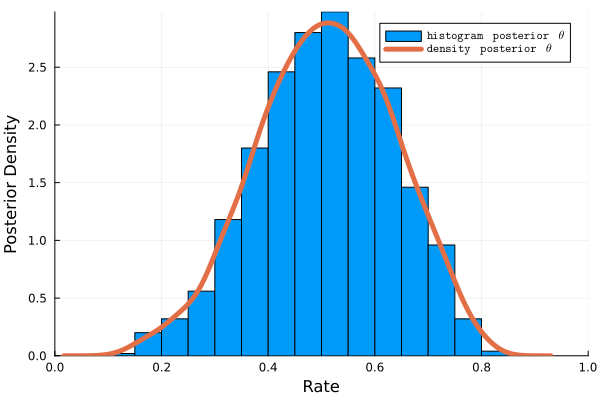

In [4]:
k = 5
n = 10

@model function BinomialModel(k)
    theta ~ Beta(1, 1)
    k ~ Binomial(n, theta)
end

iterations = 1_000
ϵ = 0.05
τ = 10

chain = sample(BinomialModel(k), HMC(ϵ, τ), iterations)

p = histogram(chain[:theta],
    label=L"\mathtt{histogram \quad posterior} \quad \theta", normalize=true, fmt=format)
density!(chain[:theta],
    label=L"\mathtt{density \quad posterior} \quad \theta", lw=5)

ylabel!("Posterior Density")
xlabel!("Rate")
xlims!(0, 1.0)

In [5]:
chain

Chains MCMC chain (1000×11×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.35 seconds
Compute duration  = 2.35 seconds
parameters        = theta
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

       theta    0.5081    0.1280    0.0110   137.3787   381.2169    1.0094     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       theta    0.2450    0.4206    0.5108    0.6010    0.7432


## 3.2 Difference between two rates

In [6]:
k1 = 5
n1 = 10
k2 = 7
n2 = 10

@model function BinomialModel2(k1, k2)
    theta1 ~ Beta(1, 1)
    theta2 ~ Beta(1, 1)
    k1 ~ Binomial(n1, theta1)
    k2 ~ Binomial(n2, theta2)
    delta = theta2 - theta1
    return (delta=delta,)
end

iterations = 1000
ϵ = 0.05
τ = 10

m = BinomialModel2(k1, k2)
chain = sample(m, HMC(ϵ, τ), iterations)
chains_params = Turing.MCMCChains.get_sections(chain, :parameters)
quantities = generated_quantities(m, chains_params)
delta = map(x -> x[:delta], quantities);

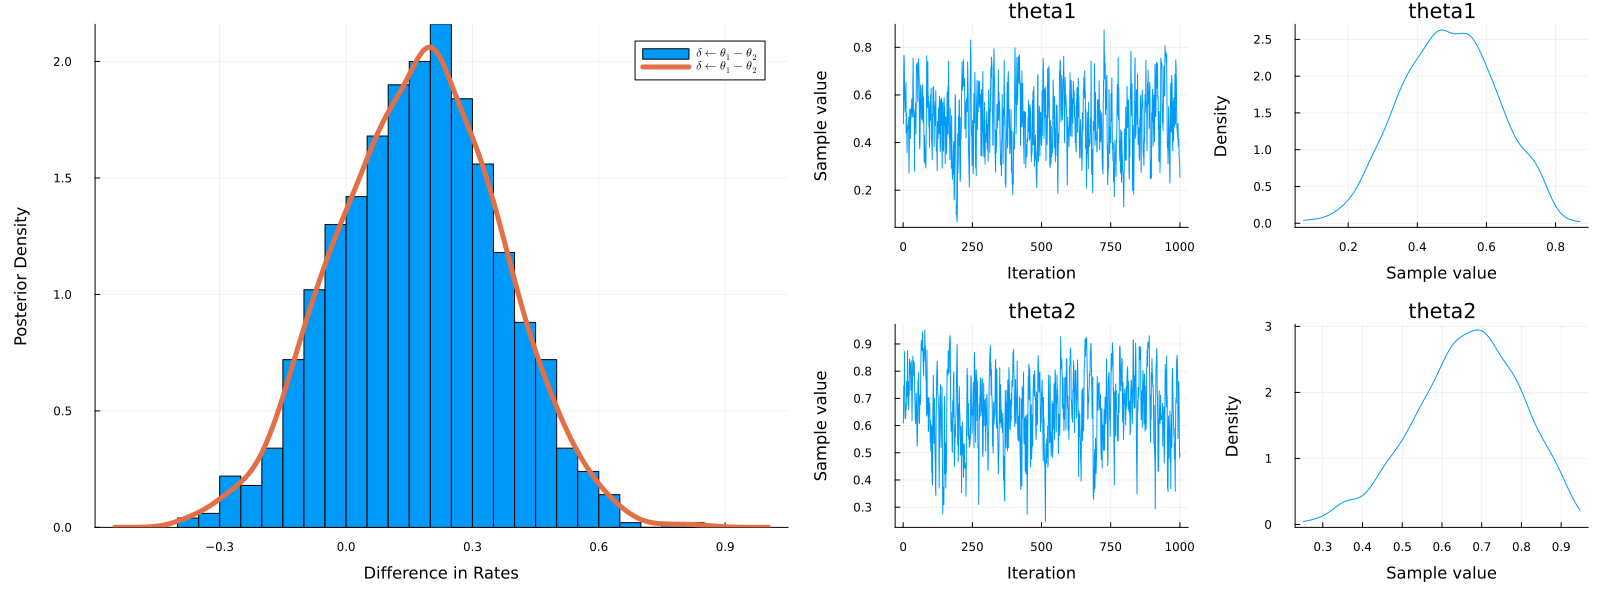

In [7]:
delta_plot = histogram(delta, label=L"\delta \leftarrow \theta_1 - \theta_2",
    normalize=true, bottom_margin=10Plots.mm)
density!(delta, label=L"\delta \leftarrow \theta_1 - \theta_2", lw=5)
xlabel!("Difference in Rates")
ylabel!("Posterior Density")

chain_plot = plot(chain, size=(1000, 600))
plot(delta_plot, chain_plot, size=(1600, 600),
    left_margin=10Plots.mm, bottom_margin=10Plots.mm, fmt=format)

## 3.3 Inferring a common rate

In [8]:
k1 = 5
n1 = 10
k2 = 7
n2 = 10

@model function BinomialModel3(k1, k2)
    theta ~ Beta(1, 1)
    k1 ~ Binomial(n1, theta)
    k2 ~ Binomial(n2, theta)
end

iterations = 1000
ϵ = 0.05
τ = 10

m = BinomialModel3(k1, k2)
chain = sample(m, HMC(ϵ, τ), iterations)

Chains MCMC chain (1000×11×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.4 seconds
Compute duration  = 0.4 seconds
parameters        = theta
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

       theta    0.5962    0.0973    0.0048   410.2530   509.7848    1.0001     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       theta    0.4061    0.5309    0.5920    0.6627    0.7859


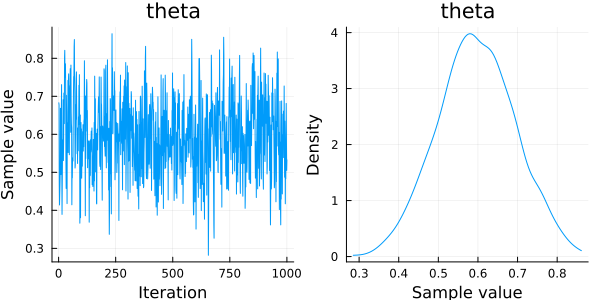

In [9]:
plot(chain, size=(600, 300), fmt=format)

## 3.4 Prior and posterior prediction

In [10]:
k = 1
n = 15

@model function BinomialModel4(k)
    theta ~ Beta(1, 1)
    theta_prior ~ Beta(1, 1)
    
    for i in eachindex(k)
        k[i] ~ Binomial(n, theta)
    end
end

iterations = 1_000
ϵ = 0.05
τ = 10

m = BinomialModel4([k])
chain = sample(m, HMC(ϵ, τ), iterations)

# same
# posterior_predictive_k = [rand(Binomial(n, e)) for e in chain[:theta] |> collect]
m_test = BinomialModel4(Vector{Union{Missing, Int32}}(undef, length(1)))
posterior_predictive = predict(m_test, chain)

Chains MCMC chain (1000×1×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = k[1]
internals         = 

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

        k[1]    1.8300    1.7505    0.1068   262.9005   341.4304    0.9994     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        k[1]    0.0000    0.0000    1.0000    3.0000    6.0000


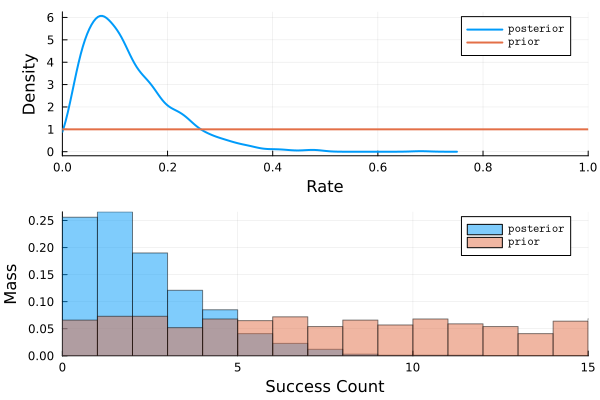

In [11]:
posterior_predictive_k = posterior_predictive[:"k[1]"] |> collect

prior_predictive_k = [rand(Binomial(n, rand(Beta(1, 1)))) for _ in 1:length(chain[:theta])]


p1 = density(chain[:theta], label=L"\mathtt{posterior}", lw=2)
plot!(Beta(1, 1), label=L"\mathtt{prior}", lw=2)
xlims!(0, 1.0)
xlabel!("Rate")
ylabel!("Density")

p2 = histogram(posterior_predictive_k, label=L"\mathtt{posterior}",
    normalize=true, bins=length(unique(posterior_predictive_k)) - 1, alpha=0.5, size=(600, 250))
xlims!(0, 15)
histogram!(prior_predictive_k, label=L"\mathtt{prior}", normalize=true,
    bins=length(unique(prior_predictive_k)) - 1, alpha=0.5)
xlabel!("Success Count")
ylabel!("Mass")

plot(p1, p2; layout=(2, 1), fmt=format)

## 3.5 Posterior Predictive

In [12]:
k1 = 0
n1 = 10
k2 = 10
n2 = 10

@model function BinomialModel5(k1, k2, n1, n2)
    theta ~ Beta(1, 1)

    for i in eachindex(k1)
        k1[i] ~ Binomial(n1, theta)
    end

    for i in eachindex(k2)
        k2[i] ~ Binomial(n2, theta)
    end
end

iterations = 1_000
ϵ = 0.05
τ = 10

m = BinomialModel5([k1], [k2], n1, n2)
chain = sample(m, HMC(ϵ, τ), iterations)

m_test = BinomialModel5(Vector{Union{Missing,Int32}}(undef, 1),
    Vector{Union{Missing,Int32}}(undef, 1), n1, n2)
posterior_predictive = predict(m_test, chain)

Chains MCMC chain (1000×2×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = k1[1], k2[1]
internals         = 

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

       k1[1]    5.0420    1.8422    0.0673   752.3085   826.7582    0.9993     ⋯
       k2[1]    4.9790    1.8297    0.0686   718.2899   605.2495    0.9993     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       k1[1]    2.0000    4.0000    5.0000    6.0000    9.0000
       k2[1]    1.0000    4.0000    5.0000    6.0000    8.0000


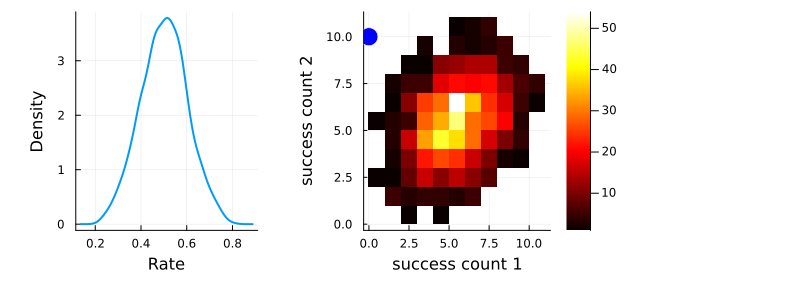

In [13]:
# postprekk1 = [rand(Binomial(n1, e)) for e in chain[:theta] |> collect]
# postprekk2 = [rand(Binomial(n2, e)) for e in chain[:theta] |> collect]
postprekk1 = posterior_predictive[:"k1[1]"] |> collect
postprekk2 = posterior_predictive[:"k2[1]"] |> collect

p1 = density(chain[:theta], lw=2, label=false)
ylabel!("Density")
xlabel!("Rate")
p2 = histogram2d(postprekk1, postprekk2,
    fc=:hot, background="black",
    xlabel="success count 1", ylabel="success count 2"
)

scatter!([k1], [k2], markersize=10, color="blue", label=false)


l = @layout [a{0.3w} a{0.44w}]
plot(p1, p2, layout=l, size=(800, 300),
    bottom_margin=10Plots.mm, left_margin=10Plots.mm, fmt=format)

## 3.6 Joint distributions

In [14]:
k = [16, 18, 22, 25, 27]
nmax = 500
m = length(k);

@model function BinomialModel6(k)
    theta ~ Beta(1, 1)

    total_n ~ DiscreteUniform(1, nmax)

    for i in eachindex(k)
        k[i] ~ Binomial(total_n, theta)
    end
end

iterations = 10_000
nchains = 4
burnin = 2_000
ϵ = 0.05
τ = 10

m = BinomialModel6(k)
chain = sample(m, SMC(), MCMCThreads(), iterations, nchains, burnin=burnin)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/fWWW0/src/sample.jl:296
Sampling (1 threads): 100%|█████████████████████████████| Time: 0:00:42


Chains MCMC chain (10000×4×4 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 4
Samples per chain = 10000
Wall duration     = 61.07 seconds
Compute duration  = 60.79 seconds
parameters        = theta, total_n
internals         = lp, weight

Summary Statistics
  parameters       mean        std      mcse    ess_bulk    ess_tail      rhat ⋯
      Symbol    Float64    Float64   Float64     Float64     Float64   Float64 ⋯

       theta     0.1909     0.1455    0.0035   1666.1629   1416.6603    1.0016 ⋯
     total_n   192.8853   130.5471    3.3571   1638.2985   1403.6545    1.0031 ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%      50.0%      75.0%      97.5% 
      Symbol   Float64   Float64    Float64    Float64    Float64 

       theta    0.0440    0.0762     0.1408     0.2656     0.5662
     total_n   39.0000   82.0000   153.0000   284.0000   477.0000


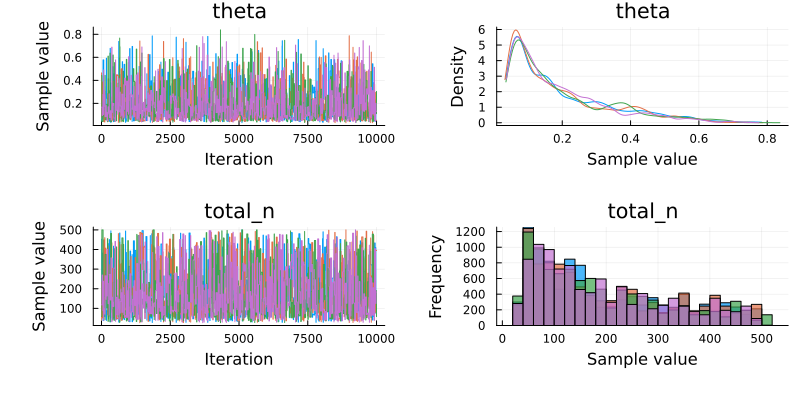

In [15]:
plot(chain, size=(800, 400),
    bottom_margin=10Plots.mm, left_margin=10Plots.mm, fmt=format)

In [16]:
posttheta = chain[:theta] |> vec |> collect
postntotal = chain[:total_n] |> vec |> collect

maximum_likelihood = -Inf64
idx = 1

for i in eachindex(postntotal)
    log_likelihood = 0
    log_likelihood += sum([
        loggamma(postntotal[i] + 1) - loggamma(j + 1) - loggamma(postntotal[i] - j + 1) +
        j * log(posttheta[i]) + (postntotal[i] - j) * log(1 - posttheta[i])
        for j in k
    ])

    if log_likelihood > maximum_likelihood
        maximum_likelihood = log_likelihood
        idx = i
    end
end

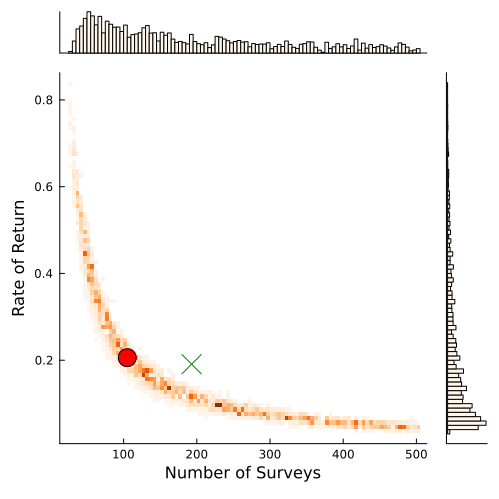

In [17]:
p = marginalhist(postntotal, posttheta,
    fc=:Oranges_8, bins=100, size=(500, 500), fmt=format)
scatter!(p.subplots[2], [mean(postntotal)], [mean(posttheta)],
    markersize=10, color="green", markershape=:xcross, label=false)
scatter!(p.subplots[2], [postntotal[idx]], [posttheta[idx]],
    markersize=10, color="red", label=false)
xlabel!(p.subplots[2], "Number of Surveys")
ylabel!(p.subplots[2], "Rate of Return")

In [18]:
Pkg.status()

Status `~/quangtiencs_projects/bayesian-cognitive-modeling-with-turing.jl/Project.toml`
  [336ed68f] CSV v0.10.11
  [a93c6f00] DataFrames v1.6.1
⌃ [366bfd00] DynamicPPL v0.23.0
  [7073ff75] IJulia v1.24.2
  [5ab0869b] KernelDensity v0.6.7
  [b964fa9f] LaTeXStrings v1.3.0
  [2ab3a3ac] LogExpFunctions v0.3.24
  [91a5bcdd] Plots v1.38.17
  [37e2e3b7] ReverseDiff v1.15.0
  [276daf66] SpecialFunctions v2.3.0
  [f3b207a7] StatsPlots v0.15.6
  [fce5fe82] Turing v0.28.1
  [e88e6eb3] Zygote v0.6.62
Info Packages marked with ⌃ have new versions available and may be upgradable.
